# **Donald Trump Tweet Analysis**
By David Gallo, Vlara Guinot, and Leo Bonamin

# 0. Installing pyspark and spark nlp

In [6]:
!pip install -q pyspark==3.1.2 spark-nlp

In [7]:
!pip install wordcloud

# 1. Start Spark Session

In [8]:
import sparknlp

spark = sparknlp.start()
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.4.2
Apache Spark version: 3.1.2


In [9]:
# checking required jar
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars && ls -lt

total 39272
-rw-r--r-- 1 root root 40210542 Mar  9 14:44 spark-nlp_2.12-3.4.2.jar


# 2. Using custom pipelines to prepare tweets

Loading data into spark dataframe

In [10]:
df = spark.read.options(delimiter=';').format("csv").load("trump_tweets.txt")
df = df.withColumnRenamed("_c0", "text")
df = df.withColumnRenamed("_c1", "timestamp")
df.printSchema() # as we can see, there are only two columns, meaning that the data was successfully split and none of the tweets contained a semicolon
print(f"Number of rows: {df.count()}")

root
 |-- text: string (nullable = true)
 |-- timestamp: string (nullable = true)

Number of rows: 57396


Count and drop nulls

Null values:
+----+---------+
|text|timestamp|
+----+---------+
|   0|     1882|
+----+---------+



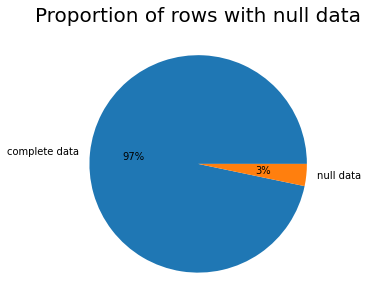

In [11]:
from pyspark.sql.functions import col, isnan, when, count
nulls_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Null values:")
nulls_df.show()
# we can see that there is no null data in the tweet text, but 1882 tweets are missing date data. In this case, we can drop rows with nulls since it's only a small subset of our total dataframe
nulls = nulls_df.collect()[0][1]
df = df.na.drop()


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = [df.count(), nulls]
labels = ['complete data', 'null data']

#Display proportion of null values 
plt.figure(figsize = (8,5))
plt.title('Proportion of rows with null data', fontsize=20)
#create pie chart
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.show()


Changing timestamp string type to spark timestamp type

In [12]:
from pyspark.sql.functions import *
# In order to be as well-optimized as possible, we want to use pyspark's to_timestamp function instead of a custom udf function to convert the timestamp strings into python timestamps
df = df.withColumn("timestamp", to_timestamp("timestamp", 'dd/MM/yyyy HH:mm:ss'))
df.printSchema()
df.show()

root
 |-- text: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)

+--------------------+-------------------+
|                text|          timestamp|
+--------------------+-------------------+
|Republicans and D...|2011-08-02 18:07:48|
|I was thrilled to...|2020-03-03 01:34:50|
|RT @CBS_Herridge:...|2020-01-17 03:22:47|
|The Unsolicited M...|2020-09-12 20:10:58|
|RT @MZHemingway: ...|2020-01-17 13:13:59|
|RT @WhiteHouse: P...|2020-01-17 00:11:56|
|“I’m running as a...|2020-10-12 22:22:39|
|Getting a little ...|2020-02-01 16:14:02|
|https://t.co/4qwC...|2020-10-23 04:52:14|
|https://t.co/VlEu...|2020-10-23 04:46:53|
|https://t.co/z5CR...|2020-10-23 04:46:49|
|https://t.co/TQCQ...|2020-10-23 04:46:45|
|RT @EricTrump: ht...|2020-10-23 04:30:19|
|         Unemploym…"|2020-03-08 04:01:46|
|RT @TomFitton: Vi...|2020-02-07 17:35:20|
|Thank you Elise! ...|2020-01-09 12:24:31|
|As per your reque...|2020-10-23 04:09:59|
|RT @marklevinshow...|2020-10-23 03:58:38|
|RT @RealRL

### 3. Parse, tokenize, clean, and transform text

Create boolean column to see if a tweet is a retweet or not, then delete RT from the start of the retweet in the text column

In [13]:
df = df.withColumn("is_retweet", when(col("text").startswith("RT "), 1).otherwise(0))
df.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------+
|text                                                                                                                                                                                                                                                                                              |timestamp          |is_retweet|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------+
|Republicans and Democrats h

Extract all arobas and hashtags into new df columns using RegexMatches pipelines

In [14]:
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

arobas_rule = "@\S\w+, starts with '@'"
hashtags_rule = "#\S+\w+, starts with '#'"

with open('arobas_rule.txt', 'w') as f:
    f.write(arobas_rule)

with open('hashtags_rule.txt', 'w') as f:
    f.write(hashtags_rule)
    
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

arobas_matcher = RegexMatcher()\
    .setInputCols('document')\
    .setStrategy("MATCH_ALL")\
    .setOutputCol("arobas")\
    .setExternalRules(path='./arobas_rule.txt', delimiter=',')

hashtags_matcher = RegexMatcher()\
    .setInputCols('document')\
    .setStrategy("MATCH_ALL")\
    .setOutputCol("hashtags")\
    .setExternalRules(path='./hashtags_rule.txt', delimiter=',')
  
regex_pipeline = Pipeline(stages=[
    documentAssembler, 
    arobas_matcher,
    hashtags_matcher
 ])

df = regex_pipeline.fit(df).transform(df)
print("Here are what the arobas and hashtag column results look like:")
df.selectExpr("arobas.result").show(truncate=False)
df.selectExpr("hashtags.result").show(truncate=False)

Here are what the arobas and hashtag column results look like:
+----------------------------------+
|result                            |
+----------------------------------+
|[]                                |
|[]                                |
|[@CBS_Herridge]                   |
|[]                                |
|[@MZHemingway]                    |
|[@WhiteHouse, @realDonaldTrump]   |
|[]                                |
|[]                                |
|[]                                |
|[]                                |
|[]                                |
|[]                                |
|[@EricTrump]                      |
|[]                                |
|[@TomFitton, @RealDonaldTrump]    |
|[]                                |
|[]                                |
|[@marklevinshow]                  |
|[@RealRLimbaugh, @realDonaldTrump]|
|[]                                |
+----------------------------------+
only showing top 20 rows

+----------+
|result   

Tokenize and clean text using more pipelines

In [15]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("token")\
      .setCaseSensitive(False)

# remove urls
normalizer_url = Normalizer() \
  .setInputCols("token") \
  .setOutputCol("token")\
  .setLowercase(True)\
  .setCleanupPatterns(["http\S+|^RT|@\S+|#\S+"]) # remove arobas, hashtags, urls, and "RT" for retweets

# strip non-alphanumeric characters
normalizer_alphanum = Normalizer() \
  .setInputCols("token") \
  .setOutputCol("token")\
  .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)

cleaning_pipeline = Pipeline().setStages([
      tokenizer,
      stopwords_cleaner,
      normalizer_url,
      normalizer_alphanum
    ])

df = cleaning_pipeline.fit(df).transform(df)
print("Our token columns results now look like this:")
df.selectExpr("token.result").show(truncate=False)

Our token columns results now look like this:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[republicans, democrats, created, economic, problems]                                                                                                                                                   

# 4. Get sentiment scores using pretrained pipeline

In [16]:
sentiment_pipeline = PretrainedPipeline("analyze_sentimentdl_use_twitter", lang = "en")  # we'll use the analyze sentiment pipeline trained on tweets instead of custom positive/negative words to analyze sentiment

df = sentiment_pipeline.fullAnnotate(df, "text")
df.show()

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[OK!]
+--------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          timestamp|is_retweet|            document|              arobas|            hashtags|               token| sentence_embeddings|           sentiment|
+--------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Republicans and D...|2011-08-02 18:07:48|         0|[{document, 0, 65...|                  []|                  []|[{token, 0, 10, r...|[{sentence_embedd...|[{category, 0, 65...|
|I was thrilled to...|2020-03-03 01:34:50|         0|[{document, 0, 27...|                  []|[{chunk, 247, 254...|[{token, 6, 13, t...|[{sentence_embedd...|[{categor

Extract just the results strings from our annotated columns, and clean our dataframe from our transformation artifacts

In [17]:
finisher = Finisher() \
    .setInputCols(["token", "arobas", "hashtags", "sentiment"]) \
    .setOutputCols(["token", "arobas", "hashtags", "sentiment"]) \
    .setIncludeMetadata(False) # set to False to remove metadata

finisher_pipeline = Pipeline(stages=[
     finisher
 ])

df = finisher_pipeline.fit(df).transform(df)

# unnest the sentiment string from the sentiment array with one element only
df = df.withColumn("sentiment", explode(df.sentiment))
df.show()

+--------------------+-------------------+----------+--------------------+----------+--------------------+---------+
|                text|          timestamp|is_retweet|              arobas|  hashtags|               token|sentiment|
+--------------------+-------------------+----------+--------------------+----------+--------------------+---------+
|Republicans and D...|2011-08-02 18:07:48|         0|                  []|        []|[republicans, dem...| negative|
|I was thrilled to...|2020-03-03 01:34:50|         0|                  []|[#KAG2020]|[thrilled, back, ...| positive|
|RT @CBS_Herridge:...|2020-01-17 03:22:47|         1|     [@CBS_Herridge]|        []|[read, letter, su...| negative|
|The Unsolicited M...|2020-09-12 20:10:58|         0|                  []|        []|[unsolicited, mai...| negative|
|RT @MZHemingway: ...|2020-01-17 13:13:59|         1|      [@MZHemingway]|        []|[friendly, tellin...| negative|
|RT @WhiteHouse: P...|2020-01-17 00:11:56|         1|[@WhiteHous

Plot results

In [18]:
pd_sentiments = df.groupBy('sentiment').count().toPandas()

In [19]:
pd_sentiments.head()

,sentiment,count
0,positive,31575
1,neutral,2947
2,negative,20992


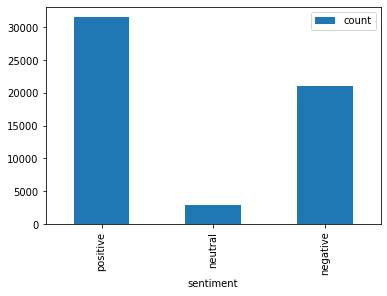

In [20]:
import pandas as pd
pd_sentiments.plot(x="sentiment", y="count", kind="bar")

Here is a breakdown between positive, neutral, and negative tweets from Trump's twitter. As we can see, there are significantly more positive and negative tweets than neutral. Anecdotally, it seems that the higher positive tweets are supporting his 2016 campaign, and retweeting praises from others.

In [21]:
df_sentiments = df.groupby('sentiment').agg(collect_list('token').alias("token"))
df_sentiments.printSchema()  # as we can see, we have a nested array of arrays in our token column that we need to now flatten
df_sentiments.token = df_sentiments.select(flatten(df_sentiments.token))
df_sentiments.show()

root
 |-- sentiment: string (nullable = true)
 |-- token: array (nullable = false)
 |    |-- element: array (containsNull = false)
 |    |    |-- element: string (containsNull = true)

+---------+--------------------+
|sentiment|               token|
+---------+--------------------+
| positive|[[thrilled, back,...|
|  neutral|[[], [], [], [], ...|
| negative|[[republicans, de...|
+---------+--------------------+



In [22]:
from collections import Counter

# collect words from our dataframe
sentiment_words = df_sentiments.select(['token']).collect() # get our dataframe into a python list
positive_words = sentiment_words[0]
negative_words = sentiment_words[2]

# unnest our nested list of words:
positive_words = [item for sublist in positive_words[0] for item in sublist]
negative_words = [item for sublist in negative_words[0] for item in sublist]

#count occurances and sort using Counter, then select the top 20 words
positive_words = Counter(positive_words).most_common(n=20)
negative_words = Counter(negative_words).most_common(n=20)

print(positive_words)
print(negative_words)

[('great', 5884), ('trump', 4041), ('thank', 3177), ('amp', 2472), ('president', 2376), ('thanks', 2003), ('america', 1522), ('new', 1470), ('donald', 1470), ('people', 1355), ('make', 1229), ('good', 1153), ('get', 1148), ('big', 1129), ('one', 1090), ('vote', 1072), ('today', 1024), ('best', 1023), ('like', 997), ('us', 995)]
[('amp', 2758), ('people', 1872), ('president', 1856), ('trump', 1781), ('us', 1649), ('democrats', 1515), ('great', 1386), ('news', 1238), ('country', 1237), ('never', 1131), ('obama', 1127), ('get', 1067), ('fake', 1029), ('many', 1016), ('time', 921), ('want', 917), ('like', 916), ('new', 886), ('china', 879), ('media', 878)]


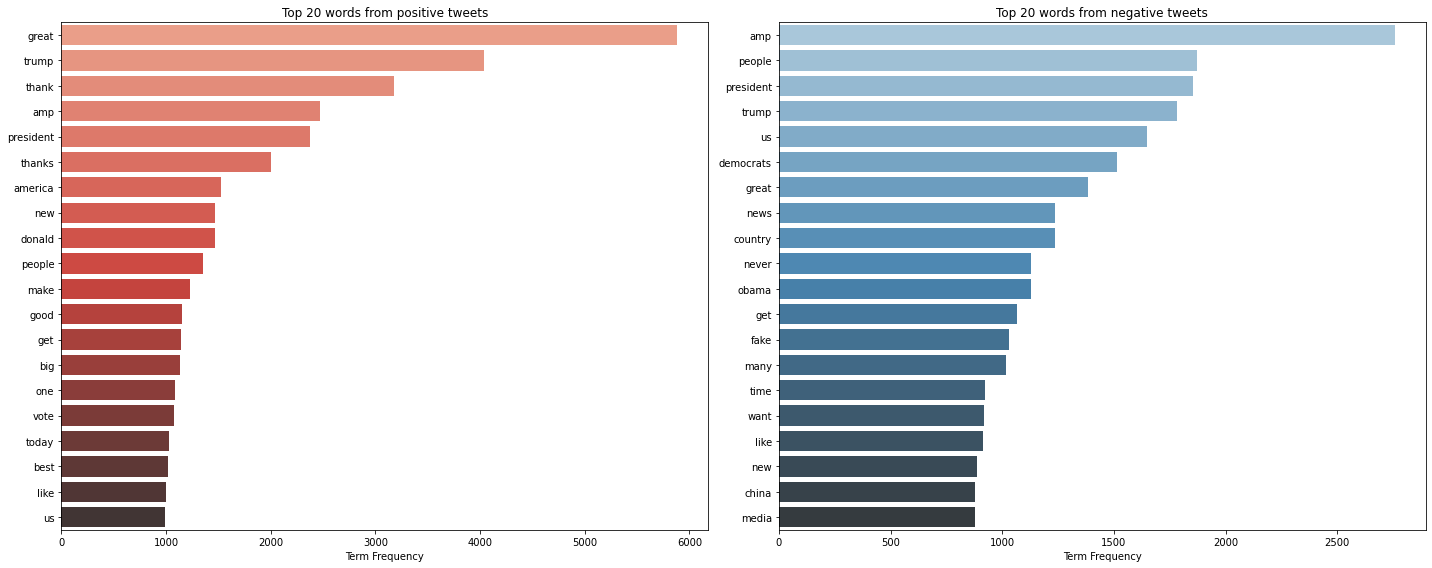

In [23]:
# plot the top 20 words from positive and negative tweets
y1 = list(list(zip(*positive_words))[0])
x1 = list(list(zip(*positive_words))[1])

y2 = list(list(zip(*negative_words))[0])
x2 = list(list(zip(*negative_words))[1])

# create graphs
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=y1, x=x1, orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 words from positive tweets")
ax[0].set_xlabel("Term Frequency")

sns.barplot(y=y2, x=x2, orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 words from negative tweets")
ax[1].set_xlabel("Term Frequency")

plt.tight_layout()
plt.show()

The results of our analysis aren't as revealing as expected. Many of the words are shared between both positive and negative tweets, but I think the differences are where some insight may be found. Negative tweets use the words news and media much more often, as well as policial figures like obama and countries like china. This falls in line with what we expect from Trump tweets, who has criticized these things often.

# 5. Extract most common words

In [24]:
# collect all words from dataframe. It's not too large to do this,
# but larger datasets would require splitting data into keys then using reducebykey to compute this in spark.
all_words = df.select("token").rdd.flatMap(lambda x: x).collect()

from itertools import chain
all_words = list(chain.from_iterable(all_words))

In [25]:
print(all_words[0][4])

b


In [26]:
#count occurances and sort using Counter, then select the top 200 words for the wordcloud
top_words = Counter(all_words)
print(top_words)

Counter({'great': 7433, 'trump': 6008, 'amp': 5411, 'president': 4385, 'thank': 3444, 'people': 3329, 'us': 2718, 'new': 2431, 'get': 2321, 'country': 2232, 'thanks': 2137, 'america': 2115, 'big': 2056, 'like': 1996, 'one': 1931, 'time': 1880, 'donald': 1855, 'never': 1820, 'good': 1816, 'make': 1813, 'news': 1766, 'democrats': 1735, 'many': 1689, 'obama': 1634, 'vote': 1610, 'today': 1569, 'going': 1504, 'back': 1459, 'much': 1393, 'want': 1386, 'american': 1358, 'see': 1313, 'years': 1270, 'job': 1251, 'even': 1247, 'run': 1245, 'best': 1228, 'fake': 1227, 'must': 1190, 'need': 1189, 'love': 1148, 'go': 1128, 'think': 1128, 'media': 1125, 'china': 1121, 'win': 1102, 'really': 1089, 'last': 1083, 'way': 1082, 'day': 1060, 'know': 1055, 'done': 1036, 'house': 1021, 'ever': 1016, 'first': 1006, 'jobs': 1003, 'work': 1003, 'bad': 1002, 'said': 991, 'states': 985, 'true': 982, 'border': 958, 'deal': 957, 'election': 947, 'state': 941, 'world': 940, 'nothing': 940, 'via': 934, 'show': 926,

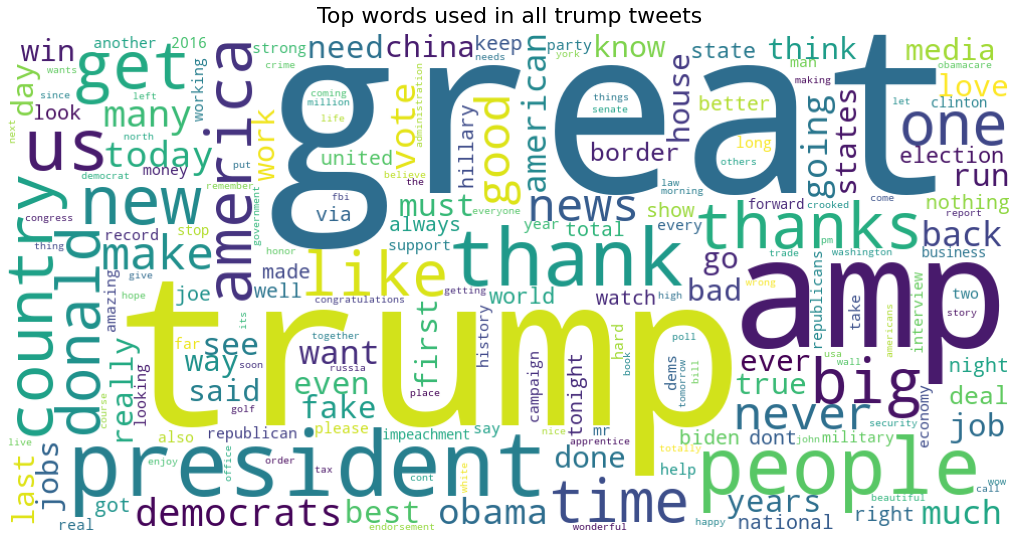

In [27]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width = 1000, height = 500)

wc.generate_from_frequencies(top_words)
plt.figure(figsize=(18,10))
plt.title("Top words used in all trump tweets", fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

As we see, the top words are not unexpected. Trump likely appears due to retweets that contain the president's name. "Great" is one of Trump's favourite words to use. 

# 6. Extract and count arobas and hashtags

In [28]:
# helper function:
from itertools import islice
def get_top(dct, n=10):
    "Helper function that gets the top 10 items from a dict as a list"
    return list(islice(dct, n))
  
# not the prettiest code, but it was the fastest implementation I could find/tweak:
def extract_and_group(dataframe, column):
  func = f"transform(array_distinct({column}),x->aggregate({column},0,(acc,y)->IF(y=x, acc+1,acc)))"
  result = dataframe.withColumn("temp", expr(func))\
  .withColumn("zip_temp", explode(arrays_zip(array_distinct(f"{column}"),("temp"))))\
  .select("zip_temp.*").withColumnRenamed("0", "elements_temp")\
  .groupBy("elements_temp").agg(sum("temp").alias("sum_temp"))\
  .collect()
  return result

def collected_df_to_dict(collected):
  collected = ({collected[i][0]: collected[i][1] for i in range(len(collected))})  # unpack our Row types from our list to extract just keys and counts
  collected = dict(sorted(collected.items(), key=lambda item: item[1], reverse=True)) # sort the dictionary by count, as of python 3.6 this will be preserved
  collected = get_top(collected.items(), n=20)
  return collected

Extract arobas from the dataframe and reduce/group them

In [29]:
arobas = extract_and_group(df, "arobas")
hashtags = extract_and_group(df, "hashtags")

Build counted python dictionaries of arobas and hashtags

In [30]:
arobas = collected_df_to_dict(arobas)
hashtags = collected_df_to_dict(hashtags)

Plot the results

In [31]:
print(arobas)
print(hashtags)

[('@realDonaldTrump', 10686), ('@FoxNews', 923), ('@WhiteHouse', 774), ('@BarackObama', 735), ('@foxandfriends', 699), ('@ApprenticeNBC', 393), ('@CNN', 392), ('@MittRomney', 318), ('@IvankaTrump', 314), ('@seanhannity', 268), ('@TeamTrump', 245), ('@DonaldJTrumpJr', 206), ('@GOP', 205), ('@EricTrump', 200), ('@DanScavino', 198), ('@nytimes', 197), ('@BreitbartNews', 183), ('@POTUS', 183), ('@GOPChairwoman', 163), ('@megynkelly', 155)]
[('#Trump2016', 729), ('#MakeAmericaGreatAgain', 518), ('#MAGA', 471), ('#CelebApprentice', 289), ('#CelebrityApprentice', 136), ('#AmericaFirst', 101), ('#TimeToGetTough', 95), ('#Trump', 74), ('#DrainTheSwamp', 73), ('#KAG2020', 70), ('#VoteTrump', 66), ('#trumpvlog', 62), ('#COVID19', 59), ('#trump2016', 57), ('#BigLeagueTruth', 52), ('#USA', 50), ('#2A', 50), ('#2016', 46), ('#TrumpForPresident', 46), ('#ImWithYou', 43)]


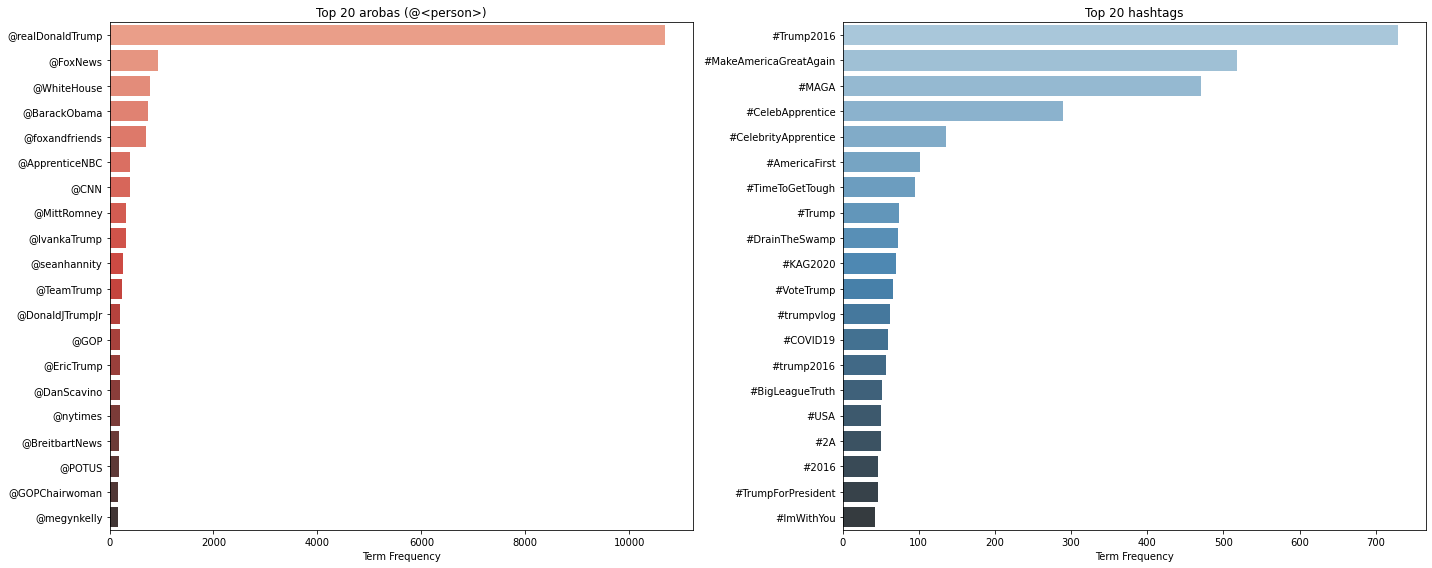

In [32]:
# top 20 arobas and hastags
y1 = list(list(zip(*arobas))[0])
x1 = list(list(zip(*arobas))[1])

y2 = list(list(zip(*hashtags))[0])
x2 = list(list(zip(*hashtags))[1])

# create graphs
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=y1, x=x1, orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 arobas (@<person>)")
ax[0].set_xlabel("Term Frequency")

sns.barplot(y=y2, x=x2, orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 hashtags")
ax[1].set_xlabel("Term Frequency")

plt.tight_layout()
plt.show()

Unsurprisingly, Donald Trump is the most tweeted person, and it dwarfs the rest of the the arobas. This is entirely due to Trump retweeting other people's tweets. Next, we see some of trump's favourite accounts to tweet at, including popular news agencies and other positical figures. 

As for hashtags, we see #Trump2016 on the top, likely as Trump was tweeting very heavily before and during his 2016 campaign for presidency. His slogan, Make America Great Again and MAGA appear next, also unsurprisnly. There don't seem to be any surprising hashtags here, as the most popular hashtags are all publicity related. 700 tweets with #Trump2016 however is quite impressive.

# 7. Extracting arobas and hashtags from pre-presidency tweets

Subset the dataframe to include only tweets before November 8, 2016

In [33]:
df_pre_2016 = df.where(df.timestamp < "2016-11-06 00:00:00")
df_pre_2016.show()

+--------------------+-------------------+----------+--------------------+--------+--------------------+---------+
|                text|          timestamp|is_retweet|              arobas|hashtags|               token|sentiment|
+--------------------+-------------------+----------+--------------------+--------+--------------------+---------+
|Republicans and D...|2011-08-02 18:07:48|         0|                  []|      []|[republicans, dem...| negative|
|@RebaForever58   ...|2013-05-19 16:23:05|         0|    [@RebaForever58]|      []|               [yes]| positive|
|@sbowlin1  Thanks...|2012-11-30 17:18:54|         0|         [@sbowlin1]|      []|   [thanksyou, love]| positive|
|@RevRome83 @Celeb...|2012-11-30 17:18:12|         0|[@RevRome83, @Cel...|      []|      [disappointed]| positive|
|@WandaSalley  Tha...|2012-12-28 20:36:56|         0|      [@WandaSalley]|      []|   [thankshave, fun]| positive|
|@bf2088 Thanks--a...|2012-12-05 14:23:18|         0|           [@bf2088]|      

Then, run the same analysis

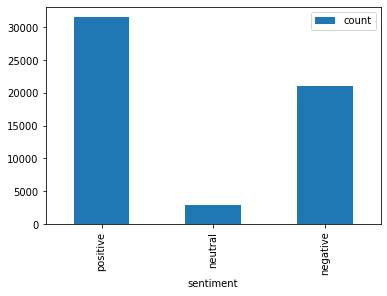

In [34]:
pd_sentiments_pre_2016 = df_pre_2016.groupBy('sentiment').count().toPandas()
pd_sentiments_pre_2016.head()
pd_sentiments.plot(x="sentiment", y="count", kind="bar")

As we can see, the overall sentiment of the tweets has not changed significantly -- more tweets are positive, as expected of someone who is supporting their own campaign before a presidency, where Trump was likely boasting about his future successes should he become president.

[('@realDonaldTrump', 8380), ('@BarackObama', 732), ('@FoxNews', 407), ('@ApprenticeNBC', 393), ('@foxandfriends', 345), ('@MittRomney', 313), ('@CNN', 249), ('@IvankaTrump', 194), ('@megynkelly', 154), ('@oreillyfactor', 130), ('@Macys', 130), ('@CelebApprentice', 127), ('@TrumpDoral', 124), ('@seanhannity', 120), ('@EricTrump', 119), ('@TrumpChicago', 102), ('@DonaldJTrumpJr', 96), ('@GOP', 94), ('@realdonaldtrump', 83), ('@Newsmax_Media', 80)]
[('#Trump2016', 728), ('#MakeAmericaGreatAgain', 502), ('#CelebApprentice', 289), ('#CelebrityApprentice', 136), ('#TimeToGetTough', 95), ('#MAGA', 76), ('#AmericaFirst', 72), ('#Trump', 67), ('#DrainTheSwamp', 66), ('#VoteTrump', 65), ('#trumpvlog', 62), ('#trump2016', 57), ('#BigLeagueTruth', 52), ('#2016', 46), ('#TrumpForPresident', 46), ('#ImWithYou', 43), ('#TrumpTrain', 39), ('#CrookedHillary', 38), ('#FITN', 37), ('#GOPDebate', 37)]


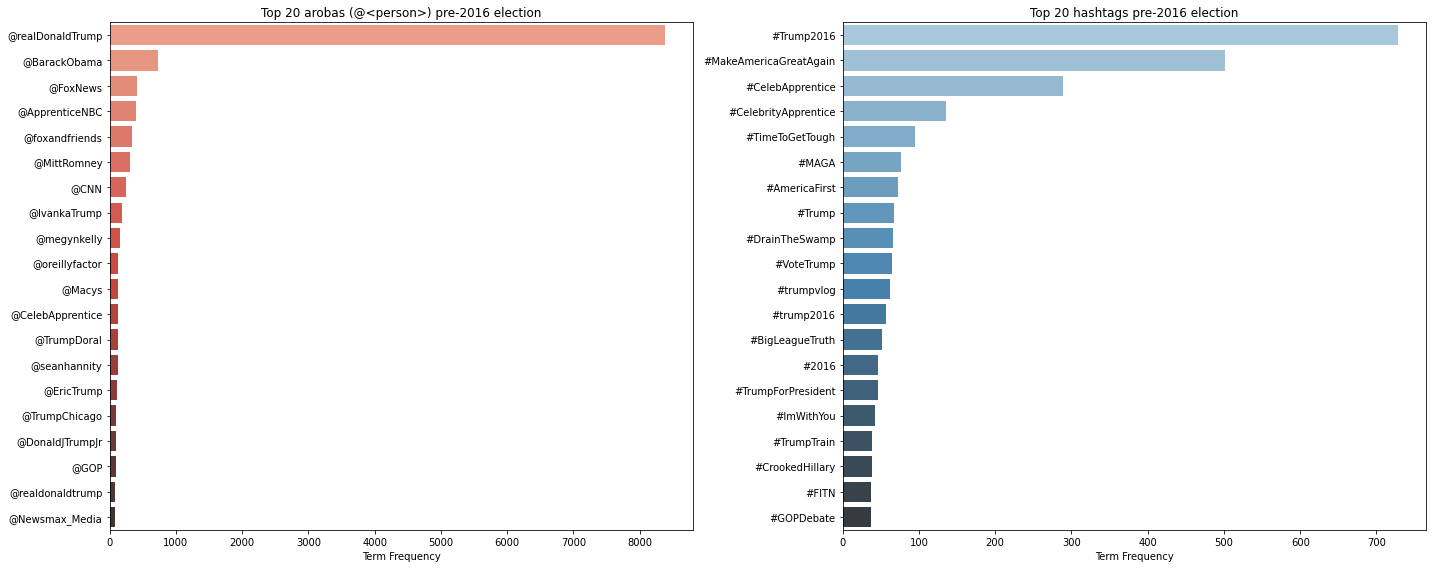

In [35]:
arobas_pre_2016 = collected_df_to_dict(extract_and_group(df_pre_2016, "arobas"))
hashtags_pre_2016 = collected_df_to_dict(extract_and_group(df_pre_2016, "hashtags"))
print(arobas_pre_2016)
print(hashtags_pre_2016)

# top 20 arobas and hastags pre-2016 election
y1 = list(list(zip(*arobas_pre_2016))[0])
x1 = list(list(zip(*arobas_pre_2016))[1])

y2 = list(list(zip(*hashtags_pre_2016))[0])
x2 = list(list(zip(*hashtags_pre_2016))[1])

# create graphs
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=y1, x=x1, orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 arobas (@<person>) pre-2016 election")
ax[0].set_xlabel("Term Frequency")

sns.barplot(y=y2, x=x2, orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 hashtags pre-2016 election")
ax[1].set_xlabel("Term Frequency")

plt.tight_layout()
plt.show()

We see however that the top hashtags haven't changed significantly. This means that Trump was likely tweeting the most about the same core subjects both before and during his presidency. One small observance is that his tweets about Celebrity Apprenticew, his popular TV show at the time, are more tweeted about.

Arobas have changed somewhat however, with more tweets about the current president at the time, Barack Obama, and fewer about Trump's family. News outlets remained high on the list however.